Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

In [1]:
# Устанавливаю spacy. Заметил, что она устанавливается без ошибок со второго раза.
import sys
!{sys.executable} -m pip install spacy;
!{sys.executable} -m spacy download en_core_web_sm;

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from pymystem3 import Mystem
import re
import spacy
from tqdm import notebook
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords as nltk_stopwords
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,make_scorer
from catboost import CatBoostClassifier
import torch
import transformers
from tqdm import notebook
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score

In [3]:
df=pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


В представленном датасете 159571 строк и 2 столбца. Текст сырой, его необходимо будет очистить и ламметизировать. Пропущенных значений нет. Целевым признаком является ['toxic']-оценка токсичности в комментарии ['text']

Text(0.5, 1.0, 'Распределение биноминальных значений при дисбалансе')

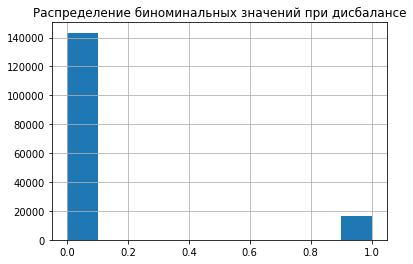

In [5]:
# Смотрю как распределен целевой признак
df['toxic'].hist()
plt.title('Распределение биноминальных значений при дисбалансе')

In [6]:
# функция upsample для создания сбалансированности выборки 
def upsample(features, target, repeat): 
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]  
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) 
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle( features_upsampled, target_upsampled, random_state=42)
    return features_upsampled, target_upsampled

# Функция для лемматизации и очистки комментариев
def lemma_by_spacy_clear(text):
    doc = nlp(text)
    doc=" ".join([token.lemma_ for token in doc])
    doc=re.sub(r'[^a-zA-Z ]',' ',doc)
  
    return " ".join(doc.split())

In [7]:
# объявляю модель spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [8]:
# Разделяю на признаки и целевой признак
features=df['text']
target=df['toxic']

In [9]:
# Чищу и лемматизирую обучающую выборку. Примерно 12 мин выполняется
corpus_lemma=features.apply(lemma_by_spacy_clear)

In [10]:
# Разделяю на обучающую и тестовую
features_train,features_test,target_train,target_test=train_test_split(corpus_lemma,target,test_size=0.3,random_state=42)

In [11]:
# Применяю функцию upsample
features_up,target_up=upsample(features_train,target_train,repeat=6)

Text(0.5, 1.0, 'Распределение биноминальных значений при дисбалансе')

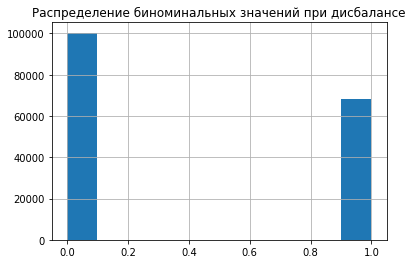

In [12]:
target_up.hist()
plt.title('Распределение биноминальных значений при дисбалансе')

Text(0.5, 1.0, 'Распределение биноминальных значений для теста (без балансировки)')

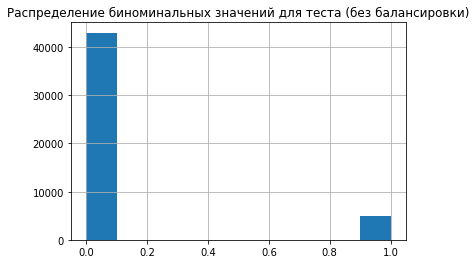

In [13]:
target_test.hist()
plt.title('Распределение биноминальных значений для теста (без балансировки)')

Как видно, дисбаланс уменьшился. Можно еще улучшить, но чтобы сильно не увеличивать выборку оставлю так.

In [14]:
nltk.download('stopwords')# загружаю стоп слова
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords) # Объявляю счетчик

In [16]:
##!!! Перевожу в векторный вид обучающую и тестовую
courpus_tfid_train=count_tf_idf.fit_transform(features_up)#Считаю Tf-idf для обучающей
courpus_tfid_test=count_tf_idf.transform(features_test)#Считаю Tf-idf для тестовой

# 2. Обучение

### model CatBoostClassifier

In [17]:
model_cat=CatBoostClassifier(loss_function="Logloss", iterations=40)

In [18]:
model_cat.fit(courpus_tfid_train,target_up)

Learning rate set to 0.5
0:	learn: 0.5474688	total: 5.91s	remaining: 3m 50s
1:	learn: 0.4909174	total: 10.9s	remaining: 3m 27s
2:	learn: 0.4616310	total: 15.7s	remaining: 3m 13s
3:	learn: 0.4408260	total: 20.7s	remaining: 3m 6s
4:	learn: 0.4232515	total: 25.2s	remaining: 2m 56s
5:	learn: 0.4076498	total: 30.1s	remaining: 2m 50s
6:	learn: 0.3952095	total: 35s	remaining: 2m 45s
7:	learn: 0.3860314	total: 39.6s	remaining: 2m 38s
8:	learn: 0.3776129	total: 44.4s	remaining: 2m 32s
9:	learn: 0.3699310	total: 49.2s	remaining: 2m 27s
10:	learn: 0.3637652	total: 54s	remaining: 2m 22s
11:	learn: 0.3547998	total: 58.7s	remaining: 2m 16s
12:	learn: 0.3492943	total: 1m 3s	remaining: 2m 11s
13:	learn: 0.3450268	total: 1m 8s	remaining: 2m 6s
14:	learn: 0.3408479	total: 1m 12s	remaining: 2m 1s
15:	learn: 0.3367189	total: 1m 17s	remaining: 1m 55s
16:	learn: 0.3333081	total: 1m 21s	remaining: 1m 50s
17:	learn: 0.3293391	total: 1m 26s	remaining: 1m 46s
18:	learn: 0.3253680	total: 1m 31s	remaining: 1m 41s

In [19]:
predict_cat=model_cat.predict(courpus_tfid_test)

In [20]:
confusion_matrix(predict_cat,target_test)

array([[41667,  1140],
       [ 1338,  3727]])

In [21]:
f1_cat=round(f1_score(predict_cat,target_test),2)
f1_cat

0.75

f-cat -> 0.75

### model RuBert

In [22]:
df_features_up=pd.DataFrame(features_up)
df_target_up=pd.DataFrame(target_up)
df_BERT_features=df_features_up.sample(n=50,random_state=42)
df_BERT_target=target_up[df_BERT_features.index]
df_BERT_target = df_BERT_target.reset_index().drop_duplicates(subset='index', keep='last').set_index('index')

In [23]:
tokenizer = transformers.BertTokenizer(
    vocab_file='/datasets/ds_bert/vocab.txt')

tokenized = df_BERT_features['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512))

max_len = max(tokenized.apply(lambda x: len(x)))

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [24]:
config = transformers.BertConfig.from_json_file(
    '/datasets/ds_bert/bert_config.json')
model = transformers.BertModel.from_pretrained(
    '/datasets/ds_bert/rubert_model.bin', config=config)

In [25]:
max_len

512

In [26]:
padded.shape[0]

50

In [27]:
batch_size = 10
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

In [28]:
features = np.concatenate(embeddings)

features.shape

(50, 768)

In [29]:
df_BERT_target.shape

(50, 1)

In [30]:
target=df_BERT_target

In [31]:
features_train,features_test,target_train,target_test=train_test_split(features,target,test_size=0.5,random_state=42)

In [32]:
model=LogisticRegression().fit(features_train,target_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [33]:
predict=model.predict(features_test)
accuracy=accuracy_score(predict,target_test)

In [34]:
confusion_matrix(predict,target_test)

array([[12,  6],
       [ 2,  5]])

In [35]:
f1_line=f1_score(predict,target_test)

In [36]:
f1_line

0.5555555555555556

f1_line ~ 0.56 -> слабое значение метрики

# 3. Выводы

In [37]:
razult=np.array([f1_line,f1_cat])

rezult_df=pd.DataFrame(razult,index=['LogisticRegression','CatBoostClassifier'])
rezult_df.set_axis(['F1'],axis='columns',inplace=True)
rezult_df

,F1
LogisticRegression,0.555556
CatBoostClassifier,0.750000


Лучший результат CatBoostClassifier c F1 мерой 0.75